In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model 1: Mixed Language

In [ ]:
# Import the mixed language dataset
import pandas as pd
df_mixed = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/Mixed_Labelled_Data.csv')

In [ ]:
# According to previous research paper cnn architecture, used new word2vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim import models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare the data
# tokenized_sentences: list of tokenized sentences
#cleaned_labeled_text = df_merge[df_merge['sentiment'].notnull()]
tokenized_sentences = df_mixed['cleaned']

# labels: list of corresponding sentiment labels (0 for negative, 1 for positive)
labels = df_mixed['sentiment']

labels.replace("Positive", 2, inplace=True)
labels.replace("Neutral", 1, inplace=True)
labels.replace("Negative", 0, inplace=True)

# Convert labels to categorical
categorical_labels = to_categorical(labels)

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split data into train and test sets (if needed)
Xtrain, Xtest, ytrain, ytest = train_test_split(padded_sequences, categorical_labels, test_size=0.3, random_state=42, stratify=categorical_labels)

# Load the pre-trained Word2Vec embedding weights
embedding_matrix = word2vec_model.vectors

# Define the CNN architecture
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
#model.fit(padded_sequences_train, categorical_labels_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
##model.fit(Xtrain, ytrain, epochs=20, verbose=2)



# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate the model
##loss, accuracy = model.evaluate(Xtest, ytest)

# Make predictions
##predictions = model.predict(Xtest)

##print('Test Accuracy: %f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          7530900   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 7723415 (29.46 MB)
Trainable params: 192515 (752.01 KB)
Non-trainable params: 7530900 (28.73 MB)
___________

In [ ]:
pip install livelossplot

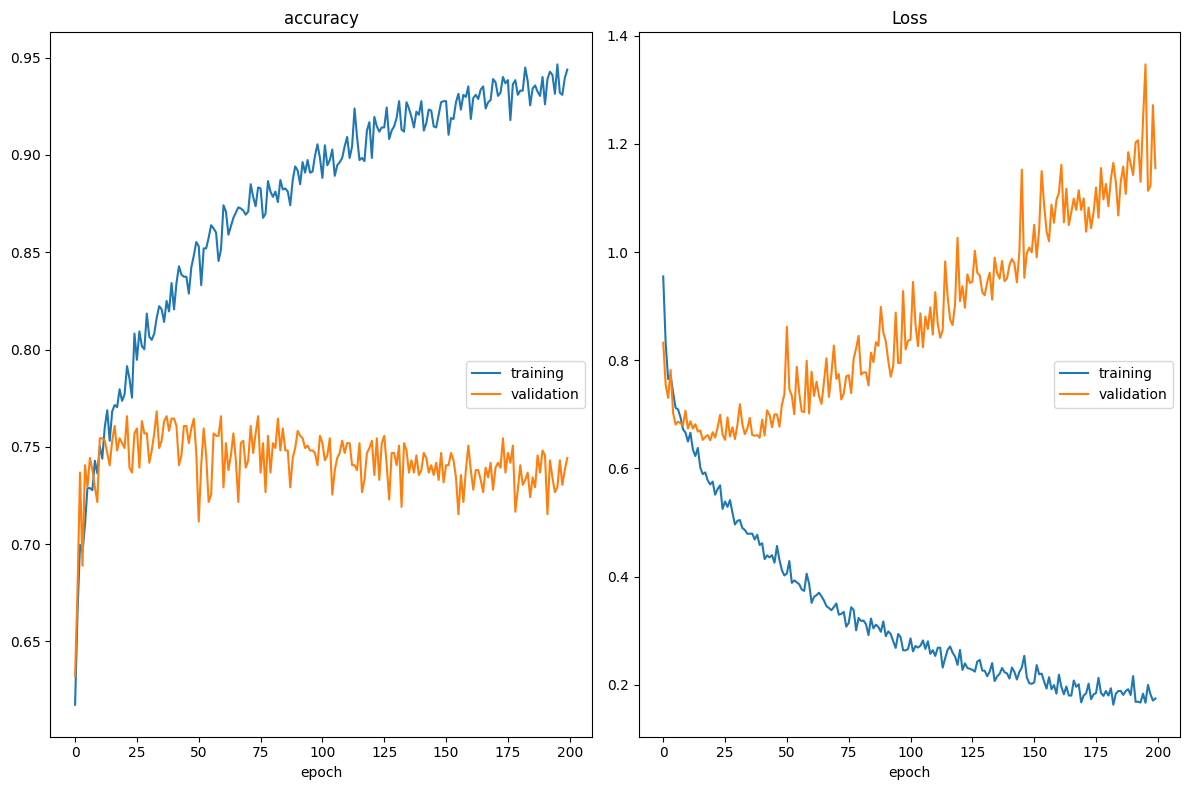

accuracy
	training         	 (min:    0.618, max:    0.947, cur:    0.944)
	validation       	 (min:    0.632, max:    0.768, cur:    0.744)
Loss
	training         	 (min:    0.163, max:    0.955, cur:    0.175)
	validation       	 (min:    0.652, max:    1.347, cur:    1.155)
58/58 - 8s - loss: 0.1748 - accuracy: 0.9438 - val_loss: 1.1550 - val_accuracy: 0.7443 - 8s/epoch - 141ms/step


In [ ]:
# To plot graph for loss and accuracy each epoch
from livelossplot import PlotLossesKeras

model.fit(Xtrain, ytrain,
          epochs=200,
          validation_data=(Xtest, ytest),
          callbacks=[PlotLossesKeras()],
          verbose=2)

In [ ]:
from sklearn.metrics import classification_report
import numpy as pd
from sklearn.metrics import confusion_matrix

ypred = model.predict(Xtest)
y_pred=np.argmax(ypred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

25/25 [==============================] - 1s 24ms/step
[[129  67   7]
 [ 46 423   9]
 [ 21  53  39]]
              precision    recall  f1-score   support

    Negative       0.66      0.64      0.65       203
     Neutral       0.78      0.88      0.83       478
    Positive       0.71      0.35      0.46       113

    accuracy                           0.74       794
   macro avg       0.72      0.62      0.65       794
weighted avg       0.74      0.74      0.73       794



In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_mixed_200epo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from gensim.models import Word2Vec
from gensim import models

# Load the saved model
saved_model_path = '/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_mixed_200epo.h5'
loaded_model1 = load_model(saved_model_path)

df_facebookProject2 = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_cleaned.csv')
tokenized_sentences = df_facebookProject2['cleaned']

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

predictions1 = loaded_model1.predict(padded_sequences)
print(predictions1)

3005/3005 [==============================] - 103s 34ms/step
[[9.7529340e-01 2.4431273e-02 2.7533731e-04]
 [7.4657329e-09 9.9999994e-01 5.7617697e-09]
 [6.1709355e-03 8.2570535e-01 1.6812366e-01]
 ...
 [9.6540040e-01 3.3430088e-02 1.1694961e-03]
 [1.7172989e-02 9.6933424e-01 1.3492737e-02]
 [7.0832306e-01 2.9109740e-01 5.7952729e-04]]


In [ ]:
print(len(predictions1))

96153


In [ ]:
import numpy as np
# Convert predictions to sentiment labels
predicted_labels = np.argmax(predictions1, axis=1)

# Map numerical labels back to original sentiment labels
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [sentiment_mapping[label] for label in predicted_labels]

# Add the predicted sentiment column to df_facebookProject2
df_facebookProject2['predicted_sentiment_model1'] = predicted_sentiments

# Display the DataFrame with the new predicted_sentiment column
print(df_facebookProject2[['cleaned', 'predicted_sentiment_model1']])

                                                 cleaned  \
0      ['outlet', 'petronas', 'bukit', 'temporarily',...   
1      ['renovate', 'pulak', '…', 'nak', 'order', 'wa...   
2      ['kota', 'kemuning', 'alert', 'menu', 'yg', 'd...   
3          ['erica', 'biggs', 'come', 'back', 'st', '🤣']   
4       ['informed', 'msia', 'day', 'already', 'closed']   
...                                                  ...   
96148                                  ['ukuran', 'bag']   
96149            ['shah', 'yati', 'yati', 'jom', 'beli']   
96150  ['macam', 'cara', 'nk', 'beli', 'niekena', 'be...   
96151              ['dah', 'settle', 'kumpul', 'kedua²']   
96152  ['potong', 'rm', 'bohongmanager', 'mall', 'ckp...   

      predicted_sentiment_model1  
0                       Negative  
1                        Neutral  
2                        Neutral  
3                        Neutral  
4                        Neutral  
...                          ...  
96148                    Neutral  

In [ ]:
df_facebookProject2['predicted_sentiment_model1'].value_counts()

Neutral     75944
Negative    13095
Positive     7114
Name: predicted_sentiment_model1, dtype: int64

In [ ]:
# Save file
df_facebookProject2.to_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_dashboard.csv', index=False)

## Model 2: English

In [ ]:
# Import the English dataset
import pandas as pd
df_eng = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/English_Labelled_Data.csv')

In [ ]:
# According to previous research paper cnn architecture, used new word2vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim import models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare the data
# tokenized_sentences: list of tokenized sentences
#cleaned_labeled_text = df_merge[df_merge['sentiment'].notnull()]
tokenized_sentences = df_eng['cleaned']

# labels: list of corresponding sentiment labels (0 for negative, 1 for positive)
labels = df_eng['sentiment']

labels.replace("Positive", 2, inplace=True)
labels.replace("Neutral", 1, inplace=True)
labels.replace("Negative", 0, inplace=True)

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert labels to categorical
categorical_labels = to_categorical(labels)

# Split data into train and test sets (if needed)
Xtrain, Xtest, ytrain, ytest = train_test_split(padded_sequences, categorical_labels, test_size=0.3, random_state=42, stratify=categorical_labels)

# Load the pre-trained Word2Vec embedding weights
embedding_matrix = word2vec_model.vectors

# Define the CNN architecture
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
#model.fit(padded_sequences_train, categorical_labels_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
##model.fit(Xtrain, ytrain, epochs=20, verbose=2)



# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate the model
##loss, accuracy = model.evaluate(Xtest, ytest)

# Make predictions
##predictions = model.predict(Xtest)

##print('Test Accuracy: %f' % (accuracy*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          7530900   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 7723415 (29.46 MB)
Trainable params: 192515 (752.01 KB)
Non-trainable params: 7530900 (28.73 MB)
_________

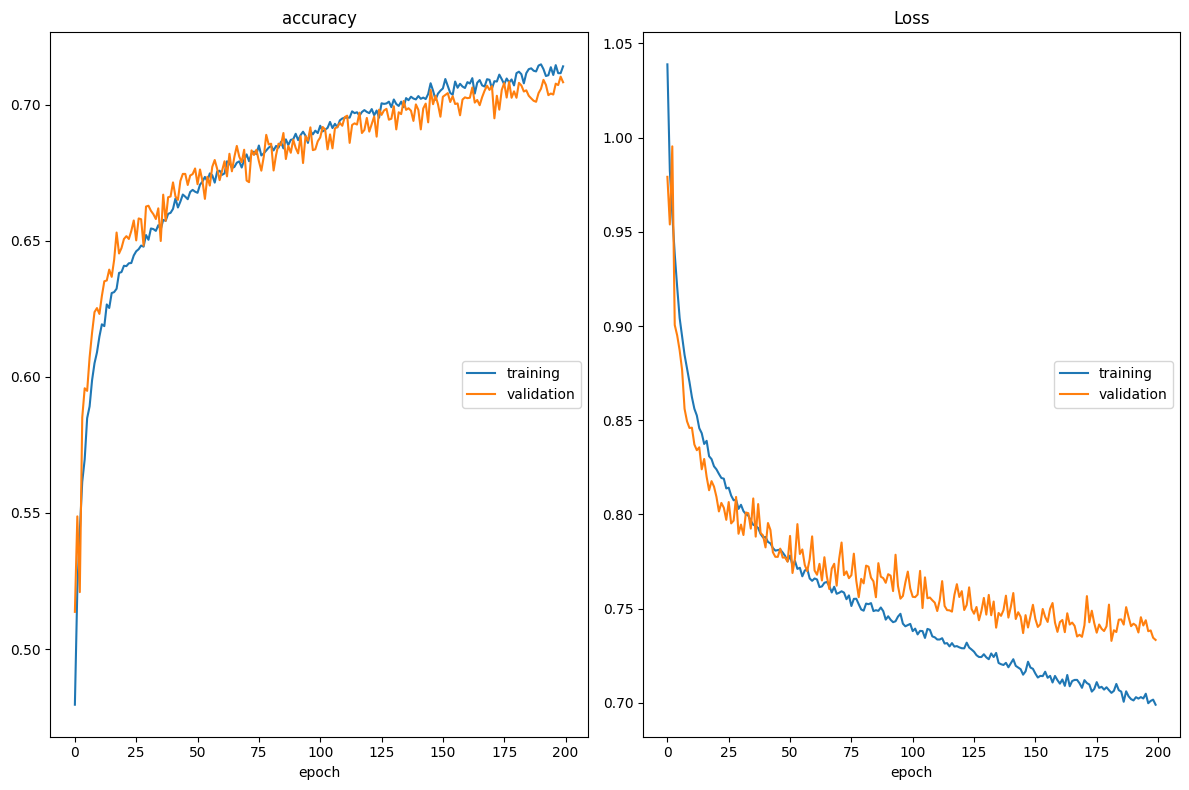

accuracy
	training         	 (min:    0.480, max:    0.715, cur:    0.714)
	validation       	 (min:    0.514, max:    0.710, cur:    0.708)
Loss
	training         	 (min:    0.699, max:    1.039, cur:    0.699)
	validation       	 (min:    0.733, max:    0.995, cur:    0.733)
986/986 - 76s - loss: 0.6990 - accuracy: 0.7140 - val_loss: 0.7334 - val_accuracy: 0.7082 - 76s/epoch - 77ms/step


In [ ]:
# To plot graph for loss and accuracy each epoch
from livelossplot import PlotLossesKeras

model.fit(Xtrain, ytrain,
          epochs=200,
          validation_data=(Xtest, ytest),
          callbacks=[PlotLossesKeras()],
          verbose=2)

In [ ]:
from sklearn.metrics import classification_report
import numpy as pd
from sklearn.metrics import confusion_matrix

ypred = model.predict(Xtest)
y_pred=np.argmax(ypred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

423/423 [==============================] - 11s 26ms/step
[[1785 1137  449]
 [ 420 4827  403]
 [ 393 1142 2959]]
              precision    recall  f1-score   support

    Negative       0.69      0.53      0.60      3371
     Neutral       0.68      0.85      0.76      5650
    Positive       0.78      0.66      0.71      4494

    accuracy                           0.71     13515
   macro avg       0.71      0.68      0.69     13515
weighted avg       0.71      0.71      0.70     13515



In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_eng_200epo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from gensim.models import Word2Vec
from gensim import models

# Load the saved model
saved_model_path = '/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_eng_200epo.h5'
loaded_model2 = load_model(saved_model_path)

df_facebookProject2 = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_dashboard.csv')
tokenized_sentences = df_facebookProject2['cleaned']

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

predictions2 = loaded_model2.predict(padded_sequences)
print(predictions2)

3005/3005 [==============================] - 90s 30ms/step
[[0.11428717 0.00260549 0.8831074 ]
 [0.1408103  0.21689203 0.6422977 ]
 [0.12973663 0.7080606  0.16220272]
 ...
 [0.3787734  0.4706713  0.15055536]
 [0.19240618 0.69036895 0.11722484]
 [0.0751366  0.72870153 0.19616178]]


In [ ]:
import numpy as np
# Convert predictions to sentiment labels
predicted_labels = np.argmax(predictions2, axis=1)

# Map numerical labels back to original sentiment labels
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [sentiment_mapping[label] for label in predicted_labels]

# Add the predicted sentiment column to df_facebookProject2
df_facebookProject2['predicted_sentiment_model2'] = predicted_sentiments

# Display the DataFrame with the new predicted_sentiment column
print(df_facebookProject2[['cleaned', 'predicted_sentiment_model2']])

                                                 cleaned  \
0      ['outlet', 'petronas', 'bukit', 'temporarily',...   
1      ['renovate', 'pulak', '…', 'nak', 'order', 'wa...   
2      ['kota', 'kemuning', 'alert', 'menu', 'yg', 'd...   
3          ['erica', 'biggs', 'come', 'back', 'st', '🤣']   
4       ['informed', 'msia', 'day', 'already', 'closed']   
...                                                  ...   
96148                                  ['ukuran', 'bag']   
96149            ['shah', 'yati', 'yati', 'jom', 'beli']   
96150  ['macam', 'cara', 'nk', 'beli', 'niekena', 'be...   
96151              ['dah', 'settle', 'kumpul', 'kedua²']   
96152  ['potong', 'rm', 'bohongmanager', 'mall', 'ckp...   

      predicted_sentiment_model2  
0                       Positive  
1                       Positive  
2                        Neutral  
3                        Neutral  
4                        Neutral  
...                          ...  
96148                    Neutral  

In [ ]:
df_facebookProject2['predicted_sentiment_model2'].value_counts()

Neutral     77568
Positive    12401
Negative     6184
Name: predicted_sentiment_model2, dtype: int64

In [ ]:
# Save file
df_facebookProject2.to_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_dashboard.csv', index=False)

## Model 3: Mixed Language + English

In [ ]:
# Import the English&Mixed dataset
import pandas as pd
df_engmix = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/English&Mixed_Labelled_Data.csv')

In [ ]:
# According to previous research paper cnn architecture, used new word2vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim import models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare the data
# tokenized_sentences: list of tokenized sentences
#cleaned_labeled_text = df_merge[df_merge['sentiment'].notnull()]
tokenized_sentences = df_engmix['cleaned']

# labels: list of corresponding sentiment labels (0 for negative, 1 for positive)
labels = df_engmix['sentiment']

labels.replace("Positive", 2, inplace=True)
labels.replace("Neutral", 1, inplace=True)
labels.replace("Negative", 0, inplace=True)

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert labels to categorical
categorical_labels = to_categorical(labels)

# Split data into train and test sets (if needed)
Xtrain, Xtest, ytrain, ytest = train_test_split(padded_sequences, categorical_labels, test_size=0.3, random_state=42, stratify=categorical_labels)

# Load the pre-trained Word2Vec embedding weights
embedding_matrix = word2vec_model.vectors

# Define the CNN architecture
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
#model.fit(padded_sequences_train, categorical_labels_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
##model.fit(Xtrain, ytrain, epochs=20, verbose=2)



# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate the model
##loss, accuracy = model.evaluate(Xtest, ytest)

# Make predictions
##predictions = model.predict(Xtest)

##print('Test Accuracy: %f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          7530900   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 7723415 (29.46 MB)
Trainable params: 192515 (752.01 KB)
Non-trainable params: 7530900 (28.73 MB)
_________

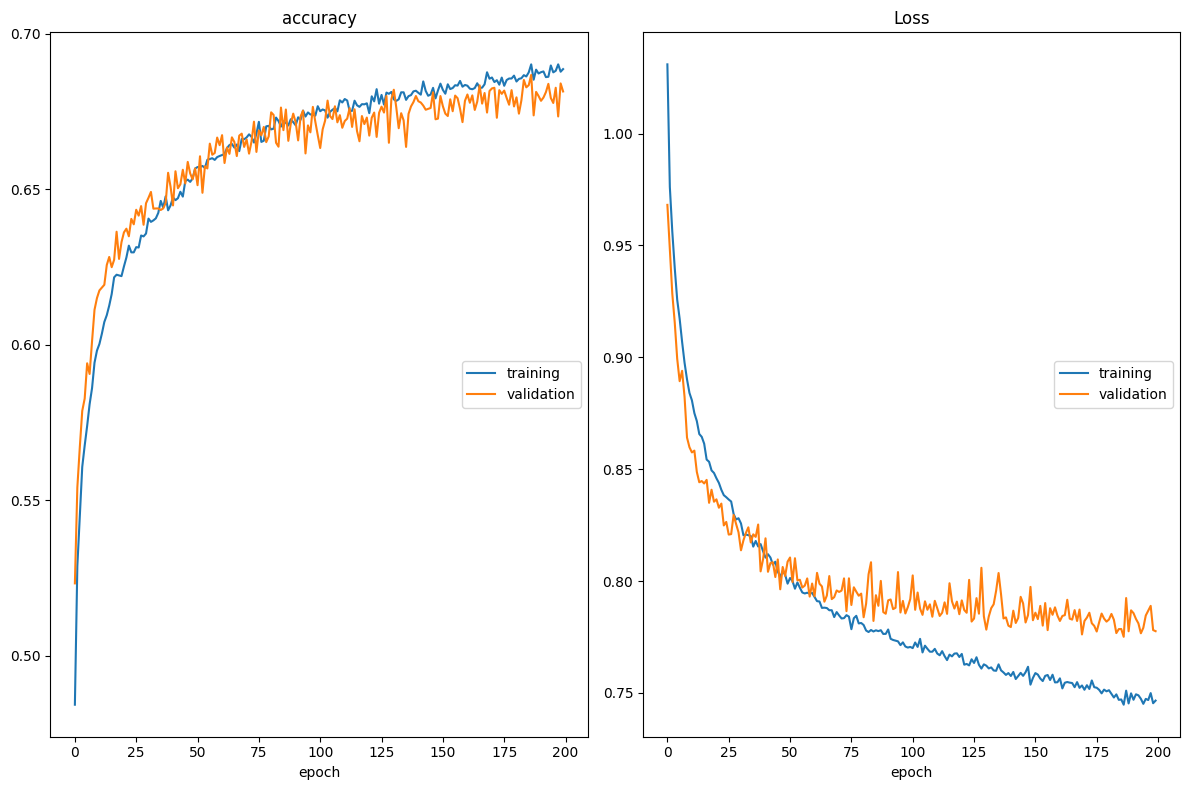

accuracy
	training         	 (min:    0.484, max:    0.690, cur:    0.689)
	validation       	 (min:    0.523, max:    0.687, cur:    0.681)
Loss
	training         	 (min:    0.745, max:    1.031, cur:    0.747)
	validation       	 (min:    0.775, max:    0.968, cur:    0.778)
1044/1044 - 77s - loss: 0.7466 - accuracy: 0.6886 - val_loss: 0.7776 - val_accuracy: 0.6814 - 77s/epoch - 73ms/step


In [ ]:
# To plot graph for loss and accuracy each epoch
from livelossplot import PlotLossesKeras

model.fit(Xtrain, ytrain,
          epochs=200,
          validation_data=(Xtest, ytest),
          callbacks=[PlotLossesKeras()],
          verbose=2)

In [ ]:
from sklearn.metrics import classification_report
import numpy as pd
from sklearn.metrics import confusion_matrix

ypred = model.predict(Xtest)
y_pred=np.argmax(ypred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

448/448 [==============================] - 13s 29ms/step
[[1724 1444  447]
 [ 415 5303  394]
 [ 404 1455 2723]]
              precision    recall  f1-score   support

    Negative       0.68      0.48      0.56      3615
     Neutral       0.65      0.87      0.74      6112
    Positive       0.76      0.59      0.67      4582

    accuracy                           0.68     14309
   macro avg       0.70      0.65      0.66     14309
weighted avg       0.69      0.68      0.67     14309



In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_engmix_200epo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from gensim.models import Word2Vec
from gensim import models

# Load the saved model
saved_model_path = '/content/drive/MyDrive/MDS Project LimJiaYee/Code/CNN_engmix_200epo.h5'
loaded_model3 = load_model(saved_model_path)

df_facebookProject2 = pd.read_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_dashboard.csv')
tokenized_sentences = df_facebookProject2['cleaned']

# Load the pre-trained Word2Vec model
word2vec_model = models.keyedvectors.load_word2vec_format('/content/drive/MyDrive/MDS Project LimJiaYee/Code/ff_word2vec_Project2.txt', binary=False)

# Create word index mapping
word_index = word2vec_model.key_to_index

# Convert tokenized sentences to sequences of word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokenized_sentences]

# Pad sequences to a fixed length
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

predictions3 = loaded_model3.predict(padded_sequences)
print(predictions3)

3005/3005 [==============================] - 88s 29ms/step
[[2.6281700e-01 7.0786854e-04 7.3647517e-01]
 [1.2153889e-01 5.1298207e-01 3.6547905e-01]
 [1.4080973e-01 7.7207547e-01 8.7114744e-02]
 ...
 [5.1498199e-01 4.2553517e-01 5.9482791e-02]
 [8.9598656e-02 8.0760741e-01 1.0279394e-01]
 [1.9022368e-01 6.3337761e-01 1.7639869e-01]]


In [ ]:
import numpy as np
# Convert predictions to sentiment labels
predicted_labels = np.argmax(predictions3, axis=1)

# Map numerical labels back to original sentiment labels
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [sentiment_mapping[label] for label in predicted_labels]

# Add the predicted sentiment column to df_facebookProject2
df_facebookProject2['predicted_sentiment_model3'] = predicted_sentiments

# Display the DataFrame with the new predicted_sentiment column
print(df_facebookProject2[['cleaned', 'predicted_sentiment_model3']])

                                                 cleaned  \
0      ['outlet', 'petronas', 'bukit', 'temporarily',...   
1      ['renovate', 'pulak', '…', 'nak', 'order', 'wa...   
2      ['kota', 'kemuning', 'alert', 'menu', 'yg', 'd...   
3          ['erica', 'biggs', 'come', 'back', 'st', '🤣']   
4       ['informed', 'msia', 'day', 'already', 'closed']   
...                                                  ...   
96148                                  ['ukuran', 'bag']   
96149            ['shah', 'yati', 'yati', 'jom', 'beli']   
96150  ['macam', 'cara', 'nk', 'beli', 'niekena', 'be...   
96151              ['dah', 'settle', 'kumpul', 'kedua²']   
96152  ['potong', 'rm', 'bohongmanager', 'mall', 'ckp...   

      predicted_sentiment_model3  
0                       Positive  
1                        Neutral  
2                        Neutral  
3                        Neutral  
4                        Neutral  
...                          ...  
96148                    Neutral  

In [ ]:
df_facebookProject2['predicted_sentiment_model3'].value_counts()

Neutral     80650
Positive    10013
Negative     5490
Name: predicted_sentiment_model3, dtype: int64

In [ ]:
# Save file
df_facebookProject2.to_csv('/content/drive/MyDrive/MDS Project LimJiaYee/Code/Dataset/Project2/facebookProject2_dashboard.csv', index=False)